# Chlorophyll Climatology

In [1]:
#directory paths
_work_dir='/g/data/jk72/as2285/miz/'
_data_dir='/g/data/jk72/MIZ/'

In [2]:
#some constants
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2021
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [3]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import odc.geo.xr

In [4]:
# import local functions
import sys
sys.path.append(_work_dir)
from utils.climat import climatology
from utils.contourf_polygons import contourf_polygons


In [5]:
%run {_work_dir}utils/plot_tools.ipynb

In [6]:
%matplotlib inline

# The Dataset

In [7]:
files = !ls -d {_data_dir}/OCCCI/*.nc

In [8]:
from os import listdir
file_names = listdir(f'{_data_dir}OCCCI/')
files = [f'{_data_dir}OCCCI/{iFile}' for iFile in file_names]

In [9]:
big_chlor_da=xr.open_mfdataset(files).chlor_a

In [10]:
chlor_da=big_chlor_da.where(big_chlor_da.lat<-40, drop=True)

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.09.1/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [11]:
chlor_da=chlor_da.odc.assign_crs("EPSG:4326")

/home/603/as2285/.local/lib/python3.8/site-packages/odc/geo/_xr_interop.py:266: UserWarning: grid_mapping=crs is not pointing to valid coordinate
  warnings.warn(


In [23]:
climat_chlor_ds=climatology(chlor_da)

In [24]:
climat_chlor_ds

<xarray.Dataset>
Dimensions:      (lat: 1200, lon: 8640, month: 12)
Coordinates:
  * lat          (lat) float64 -40.02 -40.06 -40.1 ... -89.9 -89.94 -89.98
  * lon          (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
    spatial_ref  int32 4326
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ave          (month, lat, lon) float32 dask.array<chunksize=(1, 1200, 8640), meta=np.ndarray>
    st_dev       (month, lat, lon) float32 dask.array<chunksize=(1, 1200, 8640), meta=np.ndarray>

In [25]:
anoms_da=chlor_da.groupby('time.month')-climat_chlor_ds.ave

# Climatology

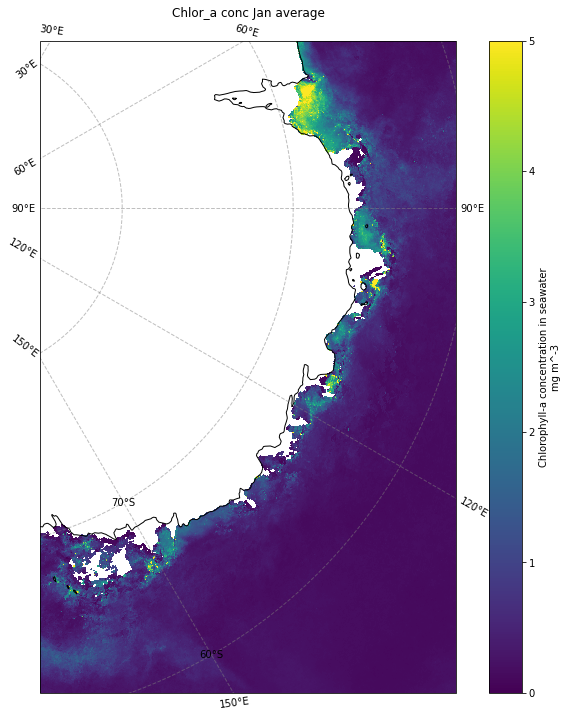

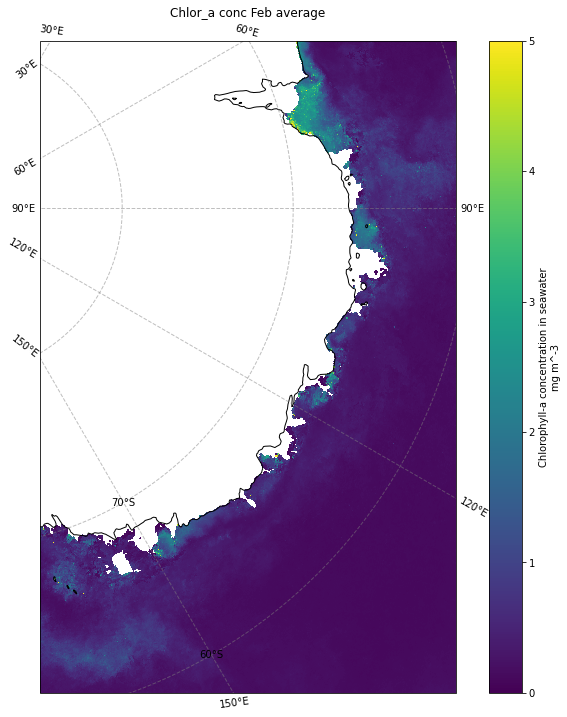

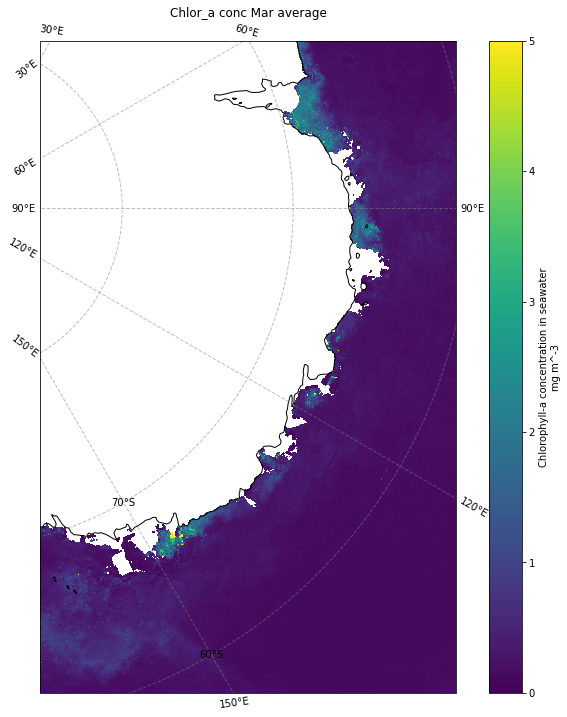

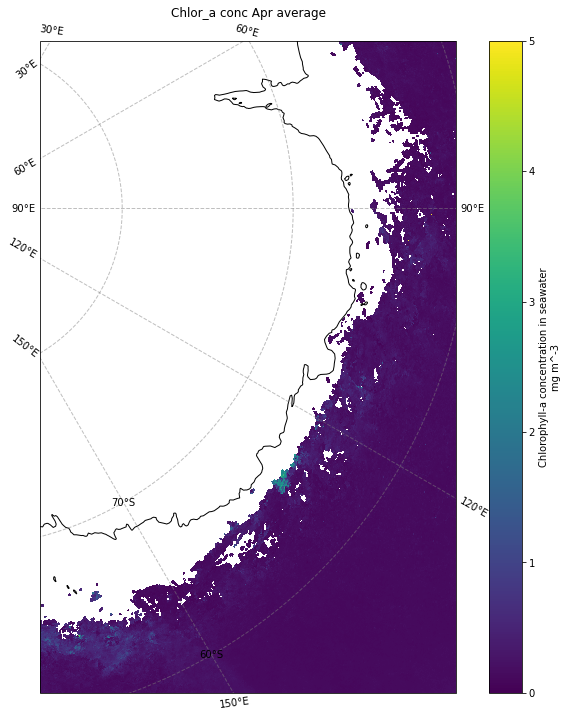

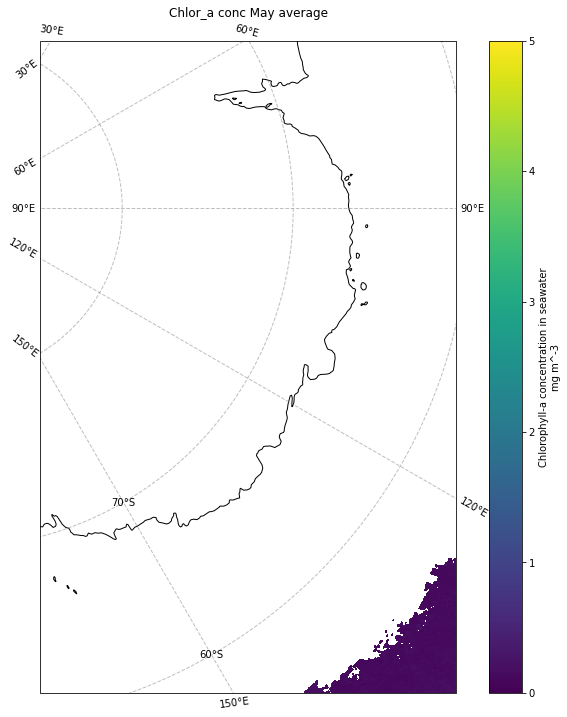

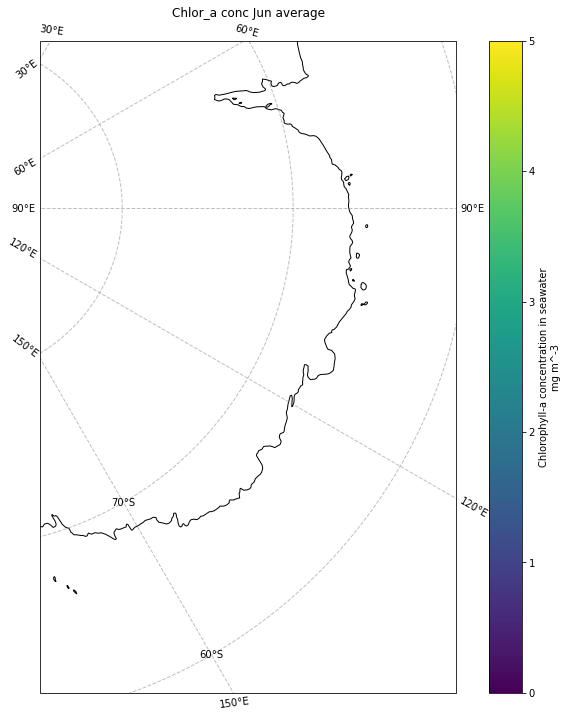

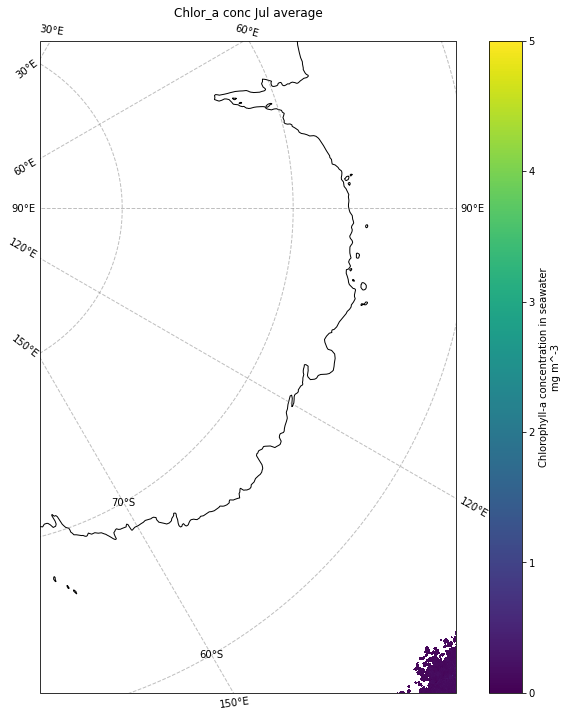

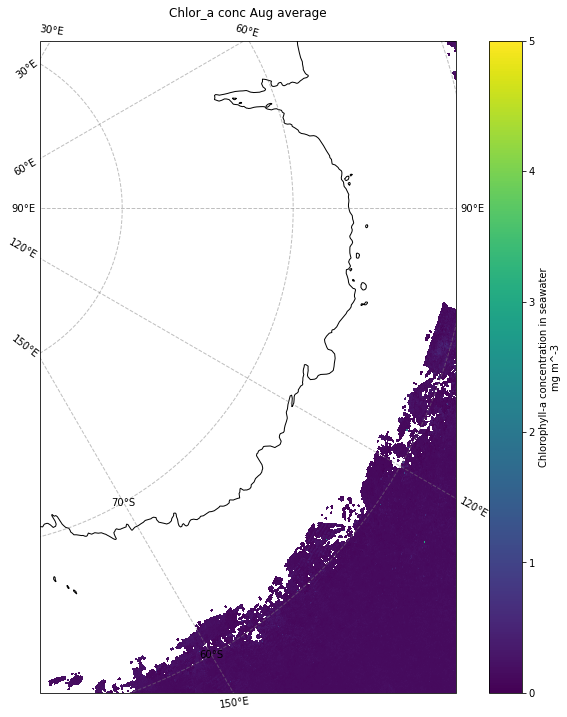

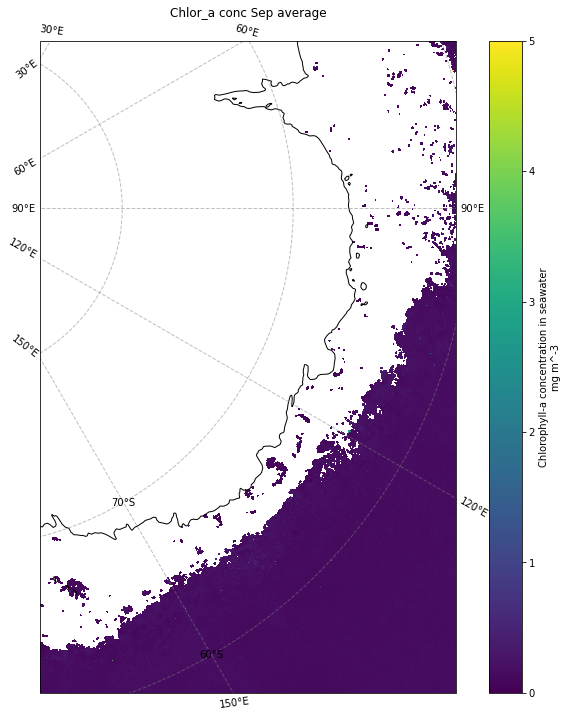

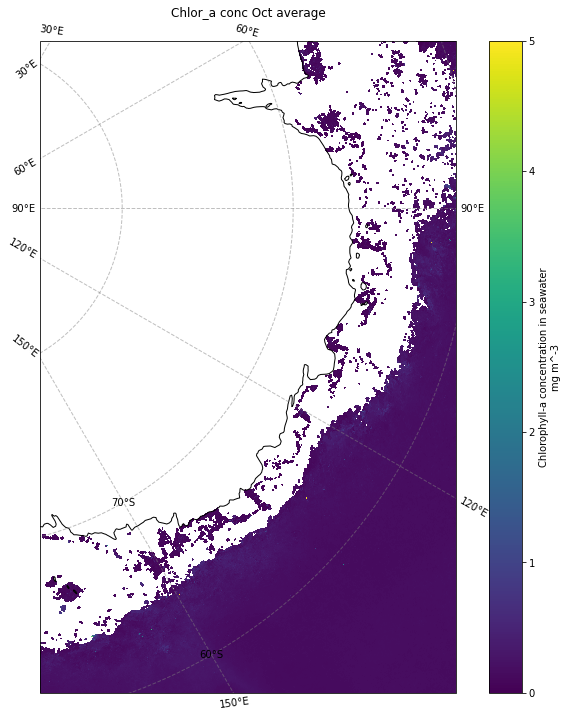

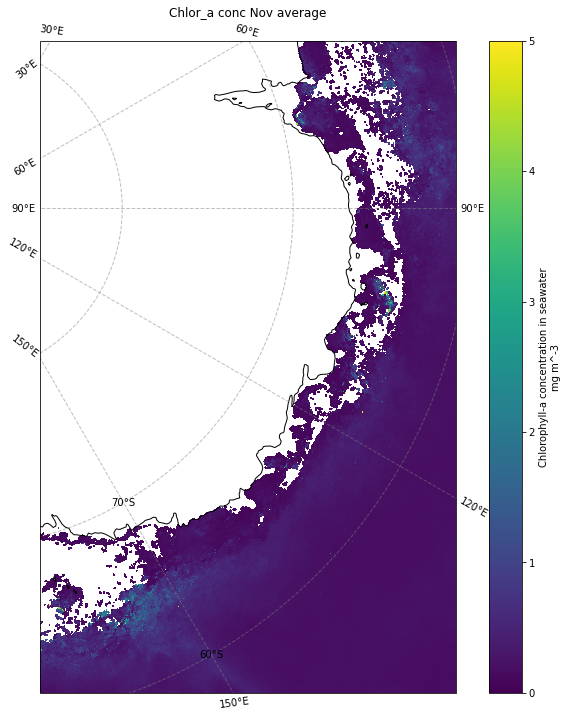

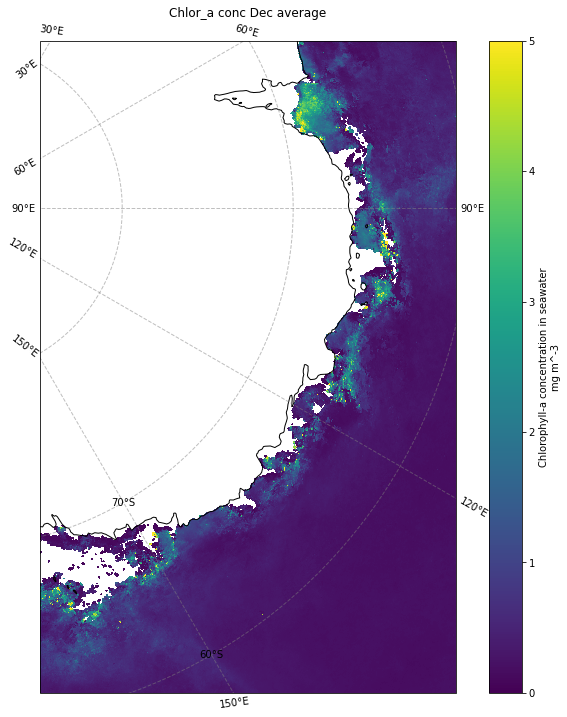

In [10]:
for MONTH in np.arange(1,13,1):

    to_plot=means_chlor_da.sel(month=MONTH).ave

    
    plt.figure(figsize=(12,12))
    ax=plt.subplot(projection=ccrs.SouthPolarStereo())


    plt.pcolormesh(
        to_plot.lon, 
        to_plot.lat, 
        to_plot,
        transform=ccrs.PlateCarree(),
        vmin=0, vmax=5
        )

    ax.coastlines()

    plt.colorbar(label='Chlorophyll-a concentration in seawater\nmg m^-3')

    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -60], crs=ccrs.PlateCarree())

    add_south_pole_gridlines(ax)
    
    plt.title(f'Chlor_a conc {months[MONTH-1]} average')
    
    plt.show()
    
    

# Anoms (Vectors)

In [41]:
#calculate the polygons - limit to 2021 as an example


gdf_ls=list()
for month in anoms_da.sel(time=slice(YEAR,YEAR)).time.values:
    
    anoms_month_da=anoms_da.sel(time=month)
    
    gdf_ls.append(
        contourf_polygons(anoms_month_da, levels=np.arange(-2.25,2.3,0.5)) 
    )

    month_str=np.datetime_as_string(anoms_month_da.time, unit='M')
    
    gdf_ls[-1].to_file(
        f'{_data_dir}/processed_chlor/anoms/contourf_polygons_{month_str}.geojson', 
        output_driver = "GeoJSON"
) 


In [42]:
gdf=gdf_ls[0]

example for jan 21

In [43]:
# plot  the polygon vectors
from ipyleaflet import Map, basemaps, GeoData, LayerGroup, LayersControl, LegendControl, projections
from ipywidgets import Layout
import matplotlib.colors as mplcolors
import matplotlib.cm

levels=gdf.level.unique()

#extract a colour for each level
cmap = matplotlib.cm.get_cmap('coolwarm_r')
colors = [mplcolors.rgb2hex(cmap(i)) for i in np.arange(0,1.01,(1/(len(levels)-1)))] 

#load each contour level as a seperate GeoData layer    
geodata_ls=[
    GeoData(
        geo_dataframe=gdf.where(gdf.level==float(levels[iLevel])),
        style={'color': colors[iLevel], 'fillColor': colors[iLevel], 'opacity':0.75, 'weight':1.9, 'dashArray':'2', 'fillOpacity':1},
    )
    for iLevel in range(len(levels))
]

#group the contours all together
grouped_layers=LayerGroup(layers=geodata_ls)#, name=f'{YEAR} Duration Anomalies')

#somewhere to show the results
spsLayout=Layout(width='600px', height='600px')
zoom = 0.85
center = [-70, 130]
map = Map(basemap=basemaps.NASAGIBS.BlueMarble3031, center=center, zoom=zoom, crs=projections.EPSG3031, layout=spsLayout )
map.add_layer(grouped_layers);

control = LayersControl(position='topright')
map.add_control(control)

#to-do: add legend

map

Map(center=[-70, 130], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

And static plots of the same data

In [11]:
course_anoms_da=anoms_da.where(
        (anoms_da.lon<EAST_ANT_LONS[1])
        *(anoms_da.lon>EAST_ANT_LONS[0])
)
    #).coarsen(lat=4).mean().coarsen(lon=4).mean()"""

/local/zv2/as2285/tmp/ipykernel_81677/2683194660.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(toPlot_anoms.lon, toPlot_anoms.lat, toPlot_anoms,vmin=-2, vmax=2, cmap='coolwarm_r')


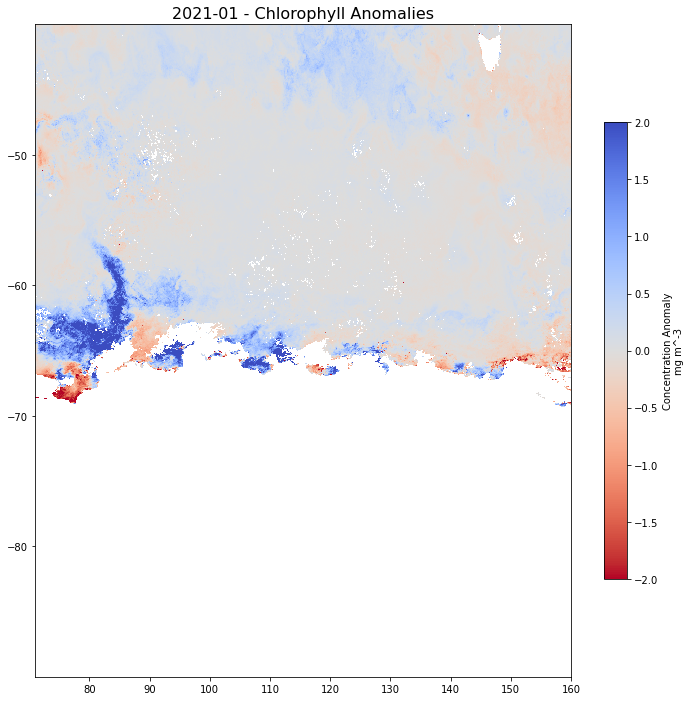

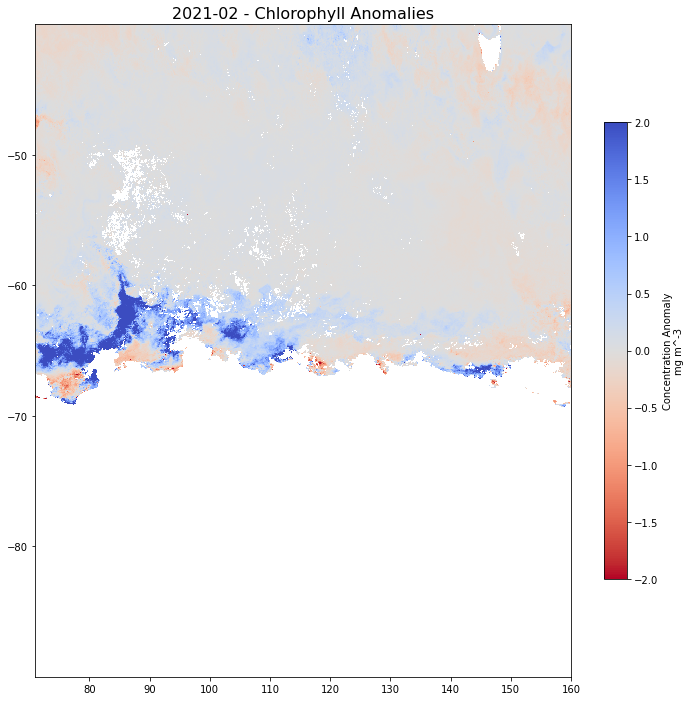

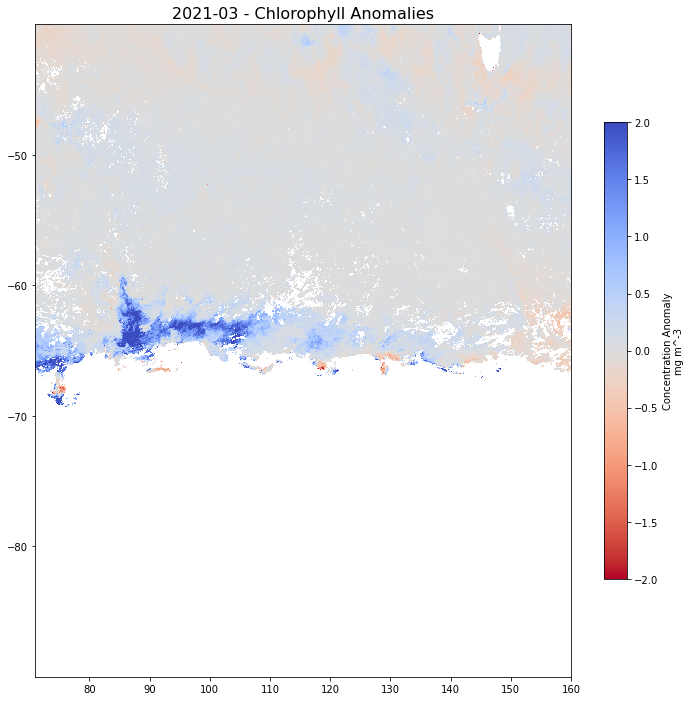

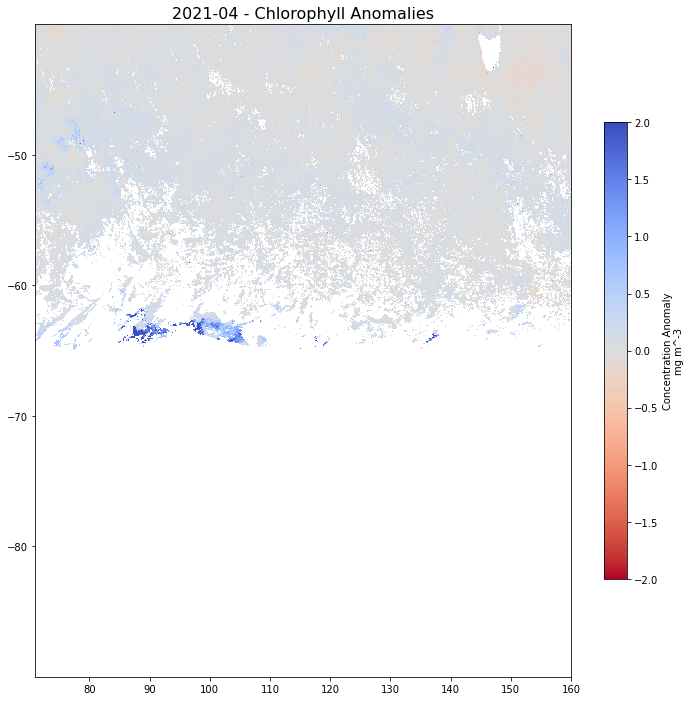

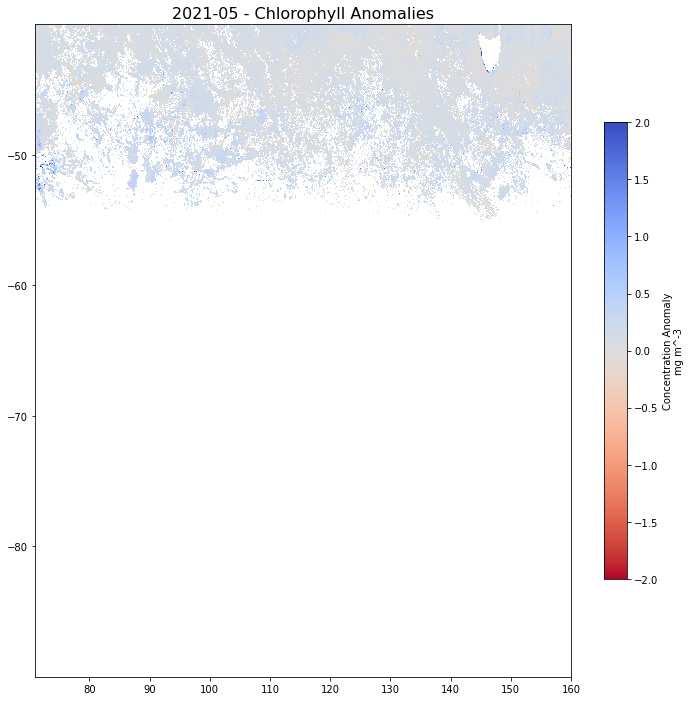

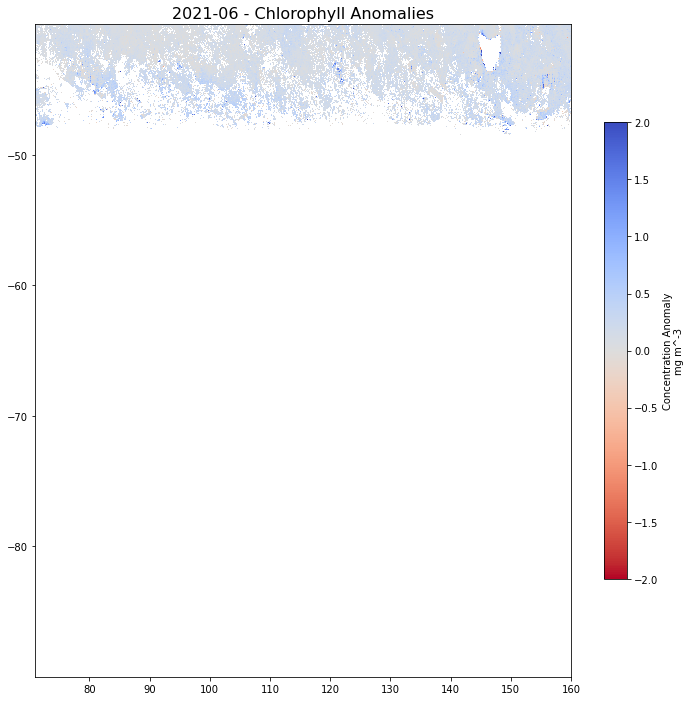

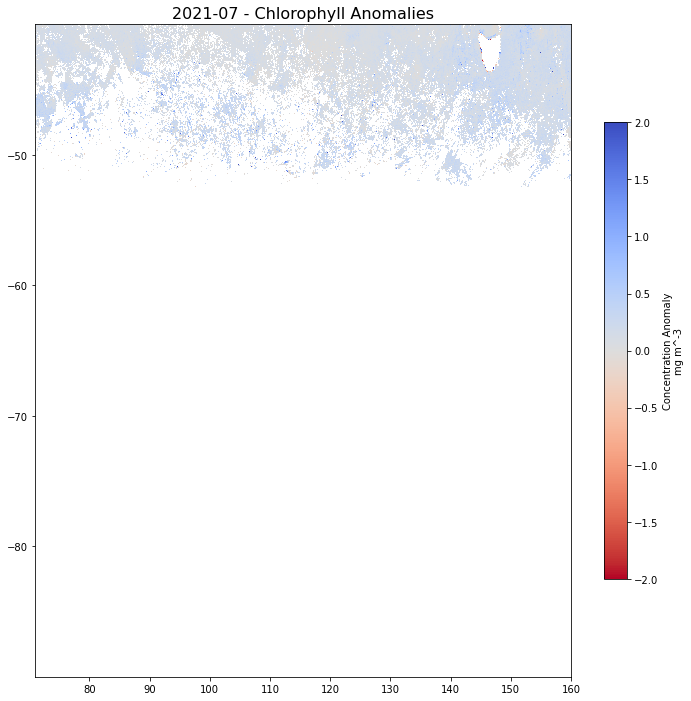

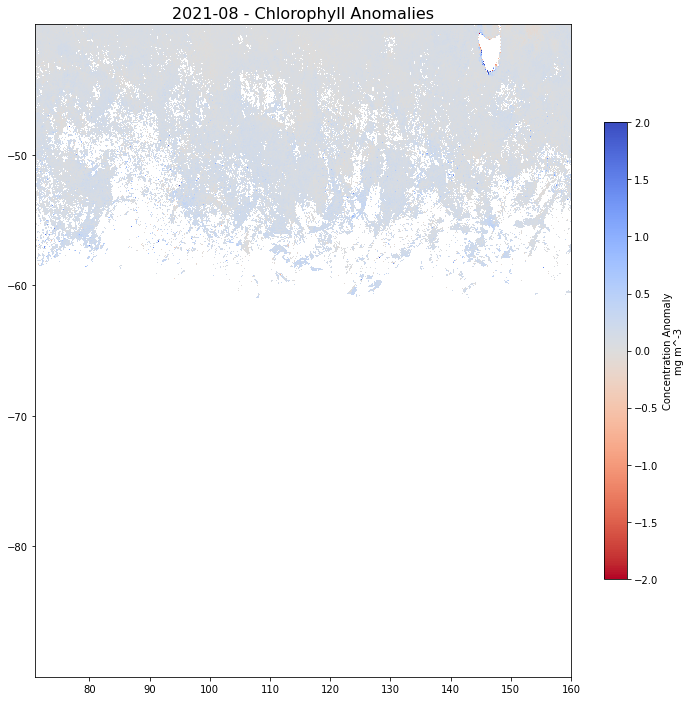

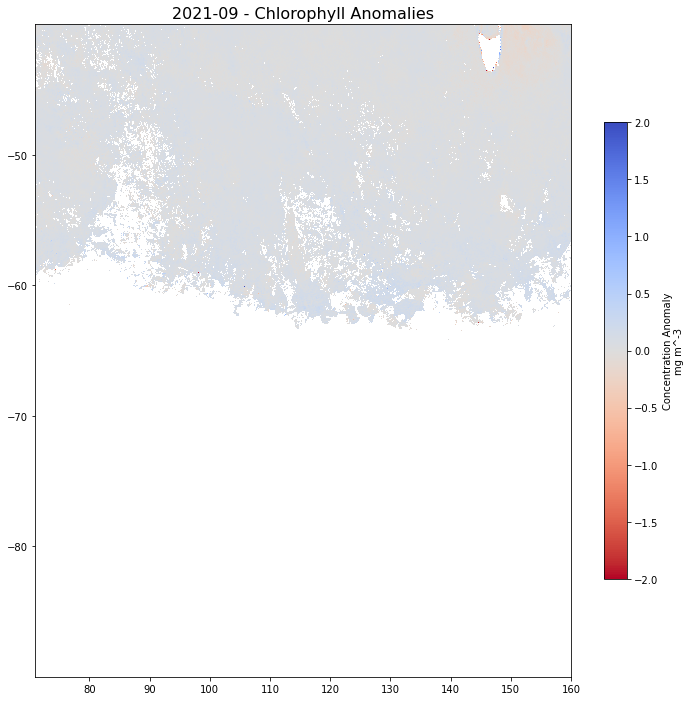

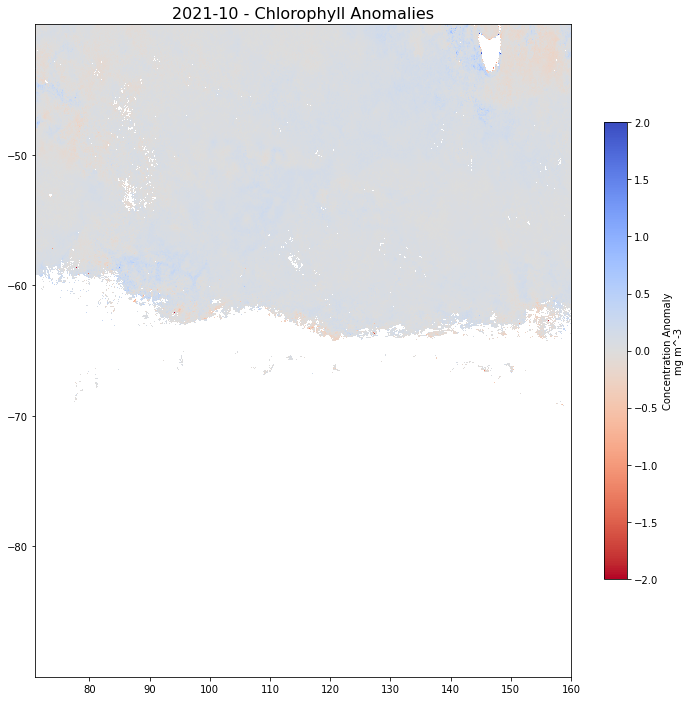

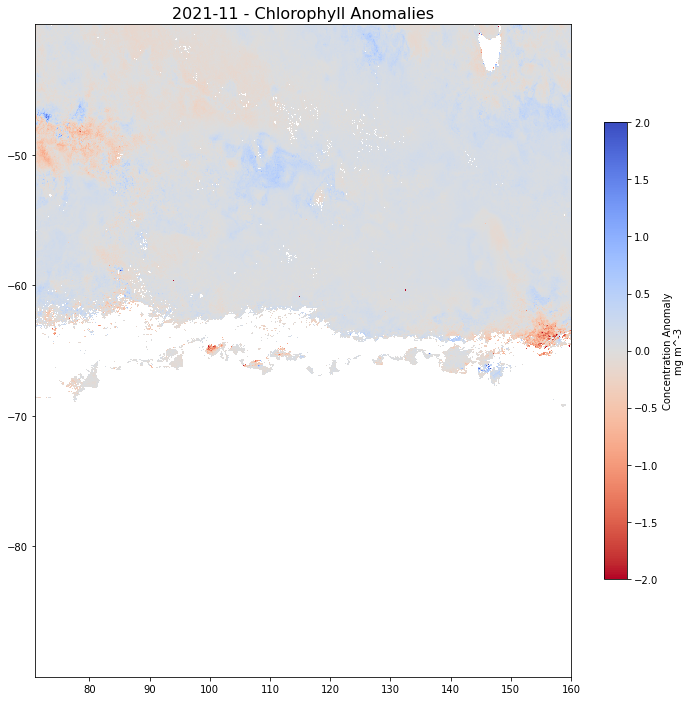

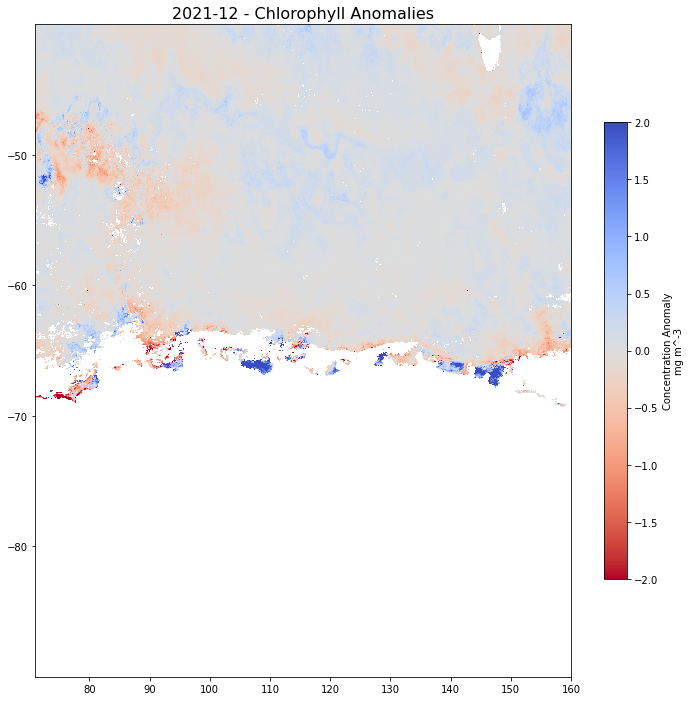

In [35]:
for iMonth in np.arange(1,13,1):
    plt.figure(figsize=(12,12))
    ax=plt.subplot()#projection=ccrs.SouthPolarStereo())

    toPlot_anoms=course_anoms_da.sel(time=np.datetime64(str(YEAR)+"-"+"%02d" %iMonth)).load()

    #chlor_a conc anoms
    plt.pcolormesh(toPlot_anoms.lon, toPlot_anoms.lat, toPlot_anoms,vmin=-2, vmax=2, cmap='coolwarm_r')
    #levels=np.arange(-2,2.1,0.5),extend='both',transform=ccrs.PlateCarree(),)




    plt.title((f'{YEAR:04.0f}-{iMonth:02.0f} - Chlorophyll Anomalies'), fontsize=16)
    plt.xlim(EAST_ANT_LONS)
    #ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55])#, crs=ccrs.PlateCarree())

    plt.colorbar(
        shrink=0.7, 
        label='Concentration Anomaly\nmg m^-3'
    )
    """
    #plot_stipling_latlon(
    #    toPlot_anoms,
    #    2*means_chlor_da.st_dev.sel(month=iMonth),
    #    ax
    #)

    add_south_pole_gridlines()

    ax.coastlines()


    #cs1.collections[0].set_label(s='Mean Sea Ice Extent') 
    #cs2.collections[0].set_label(s='Sea Ice Extent') 

    plt.legend(loc='lower right')
    plt.title(f'Chlor_a anoms {months[iMonth-1]}')
    """
    plt.show()

# EA average ??

In [26]:
eant_means_chlor_da=chlor_da.where(
    (chlor_da.lon>EAST_ANT_LONS[0])
    *(chlor_da.lon<EAST_ANT_LONS[1])
    *(chlor_da.lat<-60)
).mean(['lat','lon'])

In [32]:
eant_climat_chlor_ds=climatology(eant_means_chlor_da)

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.09.1/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


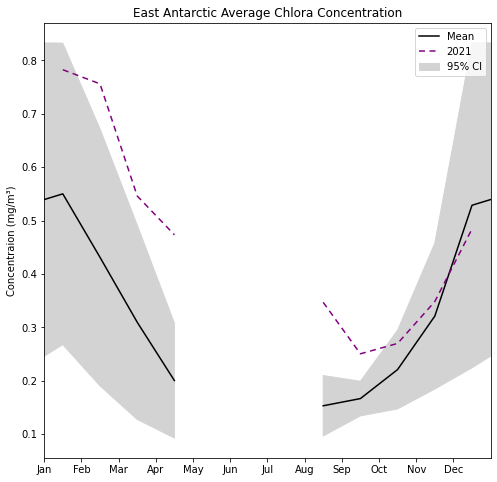

In [36]:
plt.figure(figsize=[8,8])
plt.subplot()

plot_climat_monthly(eant_climat_chlor_ds)

plot_year(eant_means_chlor_da, 2021)

#plt.yticks(
#    ticks=[0, 5e6, 10e6, 15e6, 20e6],
#    labels=['0','5','10','15','20']
#)
plt.ylabel('Concentraion (mg/m\u00b3)')

plt.title('East Antarctic Average Chlora Concentration')
plt.legend()
